In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract as pt
import math
from keras.models import load_model
pt.pytesseract.tesseract_cmd= 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
model = load_model('font_numbers.h5')

Using TensorFlow backend.


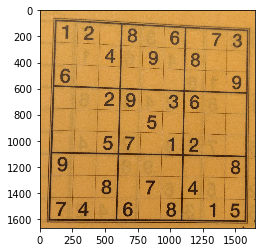

In [2]:
# Read in image of sudoku
camera = cv2.imread('orange.jpg')

# Covert to RGB for visualisation only
camera = cv2.cvtColor(camera,cv2.COLOR_BGR2RGB)
plt.imshow(camera)

## Preproccessing

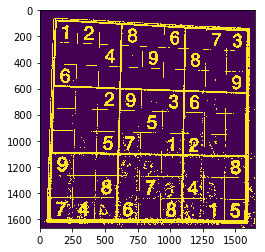

In [3]:
# Apply blur and grayscale
cam_blur = cv2.medianBlur(camera,3)
cam_gray = cv2.cvtColor(cam_blur,cv2.COLOR_BGR2GRAY)

# Apply threshold
ret, thresh = cv2.threshold(cam_gray,120,255,cv2.THRESH_BINARY_INV)

plt.imshow(thresh)

## Retrieve Contours

In [4]:
# Retrieve the contours of the image
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours based on area
cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

# Find the most likely corners for the sudoku grid
corners = None
for c in cnts:
    approx = cv2.approxPolyDP(c, 0.015 * cv2.arcLength(c, True), True)
    
    if len(approx) == 4:
        # Select the contours with largest area
        corners = approx
        break

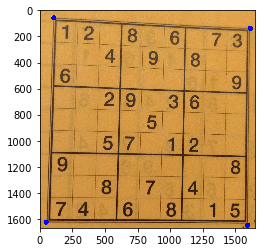

In [5]:
# Draw circles to denote corners of grid
cam_corners = camera.copy()
for i in corners:
    x,y = i[0]
    
    cv2.circle(cam_corners,(x,y),20,(0,0,255),-1)
    
plt.imshow(cam_corners)

## Select the coordinates correpsonding corners 

In [6]:
c_list = []
top_left = None
bottom_right = [0,0]
topi = 0
bottomi =0

for i, c in enumerate(corners): 
    # Retrieve coordinates and append to a new list
    x,y = c[0]
    c_list.append([x,y])
          
    if top_left ==None:
        top_left = [x,y]
        
    if x < top_left[0] and y< top_left[1]:
            top_left = [x,y]
            topi = i
            

    if x > bottom_right[0] and y> bottom_right[1]:
            bottom_right = [x,y]
            bottomi =i

    
# set the top left and bottom right coordinates to zero and remove
c_list[topi] = 0
c_list[bottomi] = 0
c_list = [x for x in c_list if x !=0]


# Obtain the coordinates for the bottom left and top right 
top_right = None
bottom_left = None
min_top_dist = float('inf')
min_bottom_dist = float('inf') 

for c in c_list:
    x = c[0]
    
    top_dist = abs(top_left[0] - x)
    bottom_dist = abs(bottom_right[0] - x)
   
     
    if top_dist <min_top_dist:
        min_top_dist = top_dist
        top_right = c
    
    if bottom_dist <min_bottom_dist:
        min_bottom_dist = bottom_dist
        bottom_left = c


## Obtain the Width and Height

In [7]:
def distance(a,b):
    '''Function to calculate euclidean distance'''
    return math.sqrt((a[0] -b[0])**2 +((a[1] -b[1])**2))

In [8]:
# Obtain the heights and select largest
height_A = distance(top_right,bottom_right)
height_B =distance(top_left,bottom_left)
height = max(int(height_A), int(height_B))

In [9]:
# Obtain the widths and select largest
width_A = distance(bottom_left,bottom_right)
width_B =distance(top_left,top_right)
width = max(int(width_A), int(width_B))

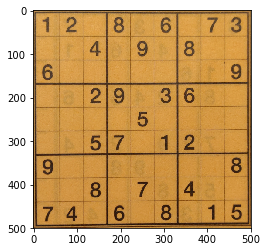

In [10]:
# Converst corners to numpy array
ordered_corners =np.array([top_right,top_left,bottom_left,bottom_right],dtype="float32")

# set the dimensions using the width and height
dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1],
                       [0, height - 1]], dtype="float32")


# Compute the perspective transform matrix and warp
grid = cv2.getPerspectiveTransform(ordered_corners, dimensions)
out = cv2.warpPerspective(camera, grid, (width, height))

# Resize and square image 
resize= cv2.resize(out,(500,500))
processed_img = cv2.rotate(resize, 2) 


plt.imshow(processed_img)

## Number detection

In [11]:
%%time
config=r'--oem 3 --psm 6 outputbase digits'

print(pt.image_to_string(processed_img,config=config))

8. 67.3

61 9

181283168
5172 4
9

4
714 8

Wall time: 739 ms


When using tesseract OCR on the transformed image the predictions are quite poor for the entire image.

In [12]:
## Grid variables
side = processed_img.shape[0]
cell_size = side//9
padding = cell_size//11
inner_cube = side//3

In [13]:
def find_blank(cell):
    ''' Function to check if cell is blank'''
    white = np.sum(cell == 255)/cell.size
    return white>0.95
   

## Binarise the image

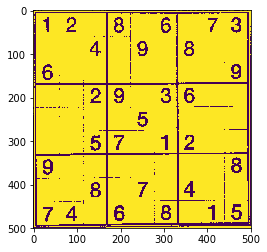

In [14]:
gray_img = cv2.cvtColor(processed_img,cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(im_bw)

True

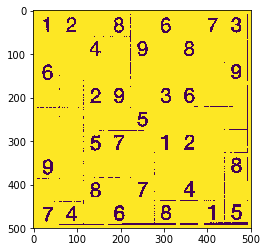

In [15]:
# Draw lines to cover up any black pixels
## Hough Line Transform is not always able to find all the lines
thickness = int(cell_size//3.4)
img = im_bw.copy()

# Outer lines
img = cv2.line(img,(0,0),(side,0),255,thickness)
img = cv2.line(img,(0,0),(0,side),255,thickness)
img = cv2.line(img,(side,0),(side,side),255,thickness)
img = cv2.line(img,(0,side),(side,side),255,thickness)

# Inner Lines
inner_thick = int(cell_size//7)
img = cv2.line(img,(0,inner_cube),(side,inner_cube),255,inner_thick)
img = cv2.line(img,(0,inner_cube*2),(side,inner_cube*2),255,inner_thick)


img = cv2.line(img,(inner_cube,0),(inner_cube,side),255,inner_thick)
img = cv2.line(img,(inner_cube*2,0),(inner_cube*2,side),255,inner_thick)
img = cv2.line(img,(0,inner_cube*2),(side,inner_cube*2),255,inner_thick)

img = cv2.line(img,(cell_size*7,0),(cell_size*7,side),255,inner_thick+5)

plt.imshow(img)
cv2.imwrite('binary.png',img)

In [16]:
%%time

numbers = []
for j in range(9):
    total = 0
    inner = []
    for i in range(9):
        # retrieve the inidviual cells of the grid
        cell = img[padding+(cell_size*j):cell_size*(j+1),(cell_size*i)+padding*2:(i+1)*cell_size]
        
        # Check to see if the cell is blank
        white = find_blank(cell)
    
        
        if not white:
            number = pt.image_to_string(cell,config=config)[0]
            try:
                number = abs(int(number))
            except ValueError:
                pass
        else:
            number = 0
        
        inner.append(number)
    print(inner)
    numbers.append(inner)


[1, 2, 0, 8, 0, 6, 0, 7, 3]
[0, 0, 4, 0, 9, 0, 8, 0, 0]
[6, 0, 0, 0, 0, 0, 0, 0, 9]
[0, 0, 2, 9, 0, 3, 6, 0, 0]
[0, 0, 0, 0, 5, 0, 0, 0, 0]
[0, 0, 5, 7, 0, 1, 2, 0, '\x0c']
[9, 0, 0, 0, 0, 0, 0, 0, 8]
[0, 0, 8, 0, 7, 0, 4, 0, 0]
[7, 4, 0, 6, '\x0c', 8, '\x0c', 1, 2]
Wall time: 5.95 s


When the image has been binarised the classification using tesseract OCR is quite good 

In [17]:
# Computer generated
def predict_number(cell,model):
    cell = cv2.resize(cell,(32,32))
    cell = cv2.bitwise_not(cell)
    cell_test = np.array([cell])
    cell_test =cell_test.reshape(1, 32, 32,1)
    cell_test = cell_test/255
    
    
    prediction = model.predict_classes(cell_test)
    return prediction[0]

In [18]:
# Handwritten mnist
def predict_digit(cell,model):
    cell = cv2.resize(cell,(28,28))
    cell = cv2.bitwise_not(cell)
    cell_test = np.array([cell])
    cell_test =cell_test.reshape(1, 28, 28,1)
    cell_test = cell_test/255
    
    
    prediction = model.predict_classes(cell_test)
    return prediction[0]

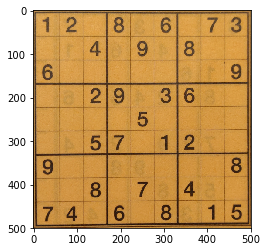

In [19]:
plt.imshow(processed_img)

'8'

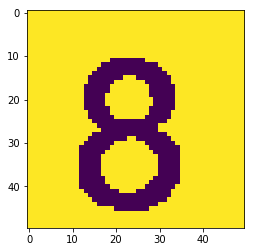

In [20]:
i=6
j=1
cell = img[padding+(cell_size*j):cell_size*(j+1),(cell_size*i)+padding:(i+1)*cell_size]

plt.imshow(cell)
pt.image_to_string(cell,config=config)[0]

In [21]:
print(predict_number(cell,model))

8


On an indidividual image the model appears to correctly predict the digit.

In [22]:
%%time

numbers = []
for j in range(9):
    total = 0
    inner = []
    for i in range(9):
        # retrieve the inidviual cells of the grid
        cell = img[padding+(cell_size*j):cell_size*(j+1),(cell_size*i)+padding:(i+1)*cell_size]
        
        # Check to see if the cell is blank
        white = find_blank(cell)
    
        
        if not white:
            number = predict_number(cell,model)
        else:
            number = 0
        
        inner.append(number)
    print(inner)
    numbers.append(inner)

[1, 4, 0, 1, 0, 6, 0, 7, 3]
[0, 0, 1, 0, 9, 0, 8, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 9]
[0, 0, 3, 1, 0, 3, 6, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 7, 0, 3, 7, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 8]
[0, 0, 1, 0, 7, 0, 4, 0, 0]
[7, 7, 0, 4, 1, 8, 1, 1, 9]
Wall time: 60 ms


When the font model is used the results are a lot poorer than the Tesseract OCR possibly due to the small size of the training set or the manner in which the images have been processed. In order to improve the results further modifications should be made to both the model and paramerters and the the image processing phase.

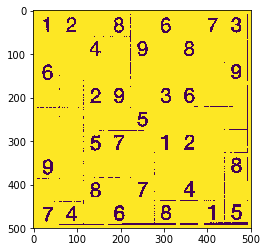

In [23]:
plt.imshow(img)